# Calculate 5 trait's scores for comments

<br> This notebook processes data for comparison by assigning a score for each of the five traits to every comment in the pre-generated Excel file <br>



In [4]:
import os
import pickle

HIGH_EXT_LABEL = "HIGH_EXT"
LOW_EXT_LABEL = "LOW_EXT"
HIGH_OPN_LABEL = "HIGH_OPN"
LOW_OPN_LABEL = "LOW_OPN"
HIGH_NEU_LABEL = "HIGH_NEU"
LOW_NEU_LABEL = "LOW_NEU"
HIGH_AGR_LABEL = "HIGH_AGR"
LOW_AGR_LABEL = "LOW_AGR"
HIGH_CON_LABEL = "HIGH_CON"
LOW_CON_LABEL = "LOW_CON"
labels = [
    HIGH_EXT_LABEL,
    LOW_EXT_LABEL,
    HIGH_OPN_LABEL,
    LOW_OPN_LABEL,
    HIGH_NEU_LABEL,
    LOW_NEU_LABEL,
    HIGH_AGR_LABEL,
    LOW_AGR_LABEL,
    HIGH_CON_LABEL,
    LOW_CON_LABEL,
]

unique_vectors_with_labels = {}
unique_paragraphs = {}

def get_trained_trait_model(model_name, low_label, high_label):
    model_path = f"./models/{model_name}.pkl"
    if os.path.exists(model_path):
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    return model

gpt_ext = get_trained_trait_model("gpt_ext", LOW_EXT_LABEL, HIGH_EXT_LABEL)
gpt_opn = get_trained_trait_model("gpt_opn", LOW_OPN_LABEL, HIGH_OPN_LABEL)
gpt_neu = get_trained_trait_model("gpt_neu", LOW_NEU_LABEL, HIGH_NEU_LABEL)
gpt_agr = get_trained_trait_model("gpt_agr", LOW_AGR_LABEL, HIGH_AGR_LABEL)
gpt_con = get_trained_trait_model("gpt_con", LOW_CON_LABEL, HIGH_CON_LABEL)


c:\Users\ARIK_LAP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
from sentence_transformers import SentenceTransformer
MODEL = "intfloat/e5-large-v2"
model = SentenceTransformer(MODEL)
vectors = model.encode("its bad bad bad!!!OMG, parties are literally my jam! Like, there's nothing better than being surrounded by all my friends, music blasting, and just vibing together. It's like every party is a chance to make memories that'll last a lifetime, you know? Plus, who doesn't love showing off their dance moves on the dance floor?"
                       , convert_to_tensor=True)
print(vectors)
print(f"Tensor shape: {vectors.shape}")

vectors_np = vectors.cpu().numpy()

# If vectors is a 1D array, reshape it to 2D
if len(vectors_np.shape) == 1:
    vectors_np = vectors_np.reshape(1, -1)

prediction = gpt_ext.predict(vectors_np)
print(f"Prediction: {prediction}")

# Get probability scores
probabilities = gpt_ext.predict_proba(vectors_np)
print(f"Probability scores: {probabilities}")

c:\Users\ARIK_LAP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([-0.0048, -0.0567,  0.0264,  ..., -0.0164,  0.0003,  0.0369])
Tensor shape: torch.Size([1024])
Prediction: ['HIGH_EXT']
Probability scores: [[0.70570127 0.29429873]]


In [ ]:
%pip install scikit-learn
%pip install sagemaker
%pip install boto3
%pip install --upgrade certifi

Deploy sagemaker endpoint, hosting the embedding model

In [ ]:
# Deploy a Sagemaker endpoint for the embedding model
from sagemaker.jumpstart.model import JumpStartModel
import json

model_id = "huggingface-sentencesimilarity-e5-large-v2"
endpoint_input = json.dumps(["its bad bad bad!!!OMG, parties are literally my jam! Like, there's nothing better than being surrounded by all my friends, music blasting, and just vibing together. It's like every party is a chance to make memories that'll last a lifetime, you know? Plus, who doesn't love showing off their dance moves on the dance floor?"])

model = JumpStartModel(model_id=model_id)
predictor = model.deploy()
response = predictor.predict(endpoint_input)
print(f"Inference:\nInput: {endpoint_input}\nResponse: {response}\n")

In [5]:
import json
import boto3

def predict(input_text, endpoint_name):
    payload = json.dumps({
        "text_inputs": [input_text],
        "mode": "embedding"
    })
    runtime_client = boto3.client('sagemaker-runtime', verify=False)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=payload
    )
    result = json.loads(response['Body'].read().decode())
    embeddings = result['embedding']
    ext_prediction = gpt_ext.predict(embeddings)
    ext_probabilities = gpt_ext.predict_proba(embeddings)
    ext_high_prob = ext_probabilities[:,0][0]
    opn_prediction = gpt_opn.predict(embeddings)
    opn_probabilities = gpt_opn.predict_proba(embeddings)
    opn_high_prob = opn_probabilities[:,0][0]
    neu_prediction = gpt_neu.predict(embeddings)
    neu_probabilities = gpt_neu.predict_proba(embeddings)
    neu_high_prob = neu_probabilities[:,0][0]
    agr_prediction = gpt_agr.predict(embeddings)
    agr_probabilities = gpt_agr.predict_proba(embeddings)
    agr_high_prob = agr_probabilities[:,0][0]
    con_prediction = gpt_con.predict(embeddings)
    con_probabilities = gpt_con.predict_proba(embeddings)
    con_high_prob = con_probabilities[:,0][0]
    return [ext_high_prob, opn_high_prob, neu_high_prob, agr_high_prob, con_high_prob]

In [6]:
# invoke the predict method and print the results
input_text = "its bad bad bad!!!OMG, parties are literally my jam! Like, there's nothing better than being surrounded by all my friends, music blasting, and just vibing together. It's like every party is a chance to make memories that'll last a lifetime, you know? Plus, who doesn't love showing off their dance moves on the dance floor?"
results = predict(input_text, "hf-sentencesimilarity-e5-large-v2-2025-04-01-22-16-58-885")
# print the 5 results of ext, opn, neu, agr and con
print("ext: ", results[0])
print("opn: ", results[1])
print("neu: ", results[2])
print("agr: ", results[3])
print("con: ", results[4])


c:\Users\ARIK_LAP\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'runtime.sagemaker.us-east-1.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ext:  0.7057011734246774
opn:  0.5268170347650369
neu:  0.3943168373589172
agr:  0.43338231145791783
con:  0.34204686733710443


In [6]:
import urllib3
urllib3.disable_warnings()

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../claude-sonnet-4-0_temp_0.7_generated_comments.csv")

# Create empty columns for the predictions
df['ext'] = np.nan
df['opn'] = np.nan
df['neu'] = np.nan
df['agr'] = np.nan
df['con'] = np.nan

try:
    # Loop through the rows and add predictions
    for i in range(len(df)):
        # Get predictions for the current comment
        predictions = predict(df['generated_comment'][i], "hf-sentencesimilarity-e5-large-v2-2025-04-01-22-16-58-885")

        # print (predictions[0])
        # Add up to 5 predictions to the dataframe
        
        df.at[i, 'ext'] = predictions[0]
        df.at[i, 'opn'] = predictions[1]
        df.at[i, 'neu'] = predictions[2]
        df.at[i, 'agr'] = predictions[3]
        df.at[i, 'con'] = predictions[4]

        if i % 100 == 0:
            print(f"Processed {i} rows out of {len(df)}")
except Exception as e:
    print(f"Error: {e}")

# Save the updated dataframe
df.to_csv("generated_comments_claude-sonnet-4-0_temp_0.7_with_predictions.csv", index=False)


Processed 0 rows out of 8842
Processed 100 rows out of 8842
Processed 200 rows out of 8842
Processed 300 rows out of 8842
Processed 400 rows out of 8842
Processed 500 rows out of 8842
Processed 600 rows out of 8842
Processed 700 rows out of 8842
Processed 800 rows out of 8842
Processed 900 rows out of 8842
Processed 1000 rows out of 8842
Processed 1100 rows out of 8842
Processed 1200 rows out of 8842
Processed 1300 rows out of 8842
Processed 1400 rows out of 8842
Processed 1500 rows out of 8842
Processed 1600 rows out of 8842
Processed 1700 rows out of 8842
Processed 1800 rows out of 8842
Processed 1900 rows out of 8842
Processed 2000 rows out of 8842
Processed 2100 rows out of 8842
Processed 2200 rows out of 8842
Processed 2300 rows out of 8842
Processed 2400 rows out of 8842
Processed 2500 rows out of 8842
Processed 2600 rows out of 8842
Processed 2700 rows out of 8842
Processed 2800 rows out of 8842
Processed 2900 rows out of 8842
Processed 3000 rows out of 8842
Processed 3100 rows 

### Data exploration

In [ ]:
%pip install seaborn
%pip install matplotlib

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = "llm models with predictions\generated_comments_gpt4.1-instruct_temp-0.7_with_predictions.csv"
modelname =  filename.split("comments_")[1].split("_with")[0]
print(modelname)

# Load the dataset
df = pd.read_csv(filename)

# describe the dataframe schema
df.info()

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
C:\Users\ARIK_LAP\AppData\Local\Temp\ipykernel_33668\3601387692.py:5: SyntaxWarning: invalid escape sequence '\g'
  filename = "llm models with predictions\generated_comments_gpt4.1-instruct_temp-0.7_with_predictions.csv"


gpt4.1-instruct_temp-0.7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18433 entries, 0 to 18432
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   post_id            18433 non-null  object 
 1   post_subreddit     18433 non-null  object 
 2   post_title         18433 non-null  object 
 3   post_text          17871 non-null  object 
 4   post_flair         18423 non-null  object 
 5   post_score         18433 non-null  int64  
 6   post_url           18413 non-null  object 
 7   post_created_utc   18433 non-null  float64
 8   post_num_comments  18433 non-null  int64  
 9   num_long_comments  18433 non-null  int64  
 10  generated_comment  18433 non-null  object 
 11  ext                18433 non-null  float64
 12  opn                18433 non-null  float64
 13  neu                18433 non-null  float64
 14  agr                18433 non-null  float64
 15  con                18433 non-null  float64
dt

#merge dfs to contain subreddit column where there is no such


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# === CONFIG ===
data_folder = "../data_for_analysis_200825/files missing subreddit column"
output_folder = "../data_for_analysis_200825"
# === Loop through all comment CSV files ===
for filename in os.listdir(data_folder):
    if not filename.endswith(".csv"):
        continue  # skip non-csv files

    file_path = os.path.join(data_folder, filename)

    # Load the dataset
    try:
        df = pd.read_csv(file_path)
        
        if 'post_subreddit' not in df.columns:
            print(f"handling {filename}: missing 'post_subreddit' column")

            subreddit_df = pd.read_csv("../reddit_posts_clean.csv")
            subreddit_df = subreddit_df.drop_duplicates(subset='post_id')

            df = df.merge(
            subreddit_df[['post_id', 'post_subreddit']], 
                on='post_id',
                how='left'  # Use 'left' to keep all rows from your original dataframe
            )

            df.to_csv(f'{output_folder}\{filename}', index=False)
    except Exception as e:
        print(f"Error: {e}")
        

<string>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\{'
<string>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\{'
C:\Users\ARIK_LAP\AppData\Local\Temp\ipykernel_28352\3542999088.py:32: SyntaxWarning: invalid escape sequence '\{'
  df.to_csv(f'{output_folder}\{filename}', index=False)


handling generated_comments_llama-3-3-70b-instruct_temp-0.0.csv: missing 'post_subreddit' column
handling generated_comments_llama-3-3-70b-instruct_temp-0.7.csv: missing 'post_subreddit' column
handling generated_comments_mixtral-8x22B-instruct-v0.1_temp-0.0.csv: missing 'post_subreddit' column
handling generated_comments_mixtral-8x22B-instruct-v0.1_temp-0.7.csv: missing 'post_subreddit' column
handling generated_comments_Qwen2.5-72B-Instruct_temp-0.0.csv: missing 'post_subreddit' column
handling generated_comments_Qwen2.5-72B-Instruct_temp-0.7.csv: missing 'post_subreddit' column


In [ ]:

print(f"Number of comments for {modelname}: {str(len(df))}")
print(f"Mean comments word count: {df['word_count'].mean()}")
print(f"Median comments word count: {df['word_count'].median()}")
print(f"Max comments word count: {df['word_count'].max()}")
print(f"Min comments word count: {df['word_count'].min()}")
print(f"Std comments word count: {df['word_count'].std()}")

In [30]:
highest_score_text = df.loc[df['neu'].idxmax(), 'generated_comment']
print("score: " + str(df.loc[df['neu'].idxmax(),'neu']))
print(highest_score_text)

score: 0.7691825068263719
I can totally relate to this. It's like your mind is playing a cruel trick on you, trying to convince you of something you know isn't true. Those intrusive thoughts can be really disorienting, making you doubt your own feelings and identity. I've experienced similar situations, and it took me a while to realize that these thoughts don't reflect my actual desires. They're just unwelcome mental visitors. Don't let them shake your confidence in your asexuality or any other label you feel comfortable with. You're not alone in this, and seeking support can be really helpful.


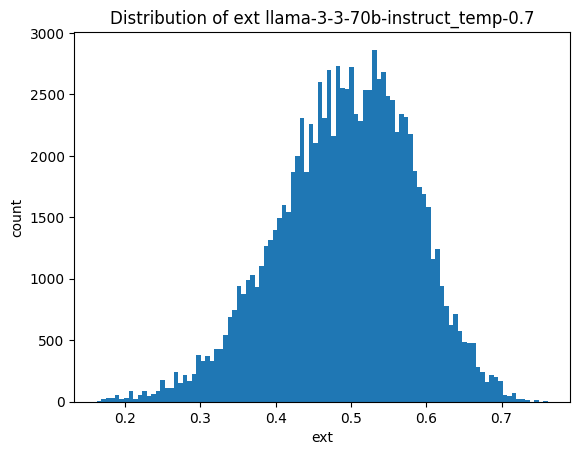

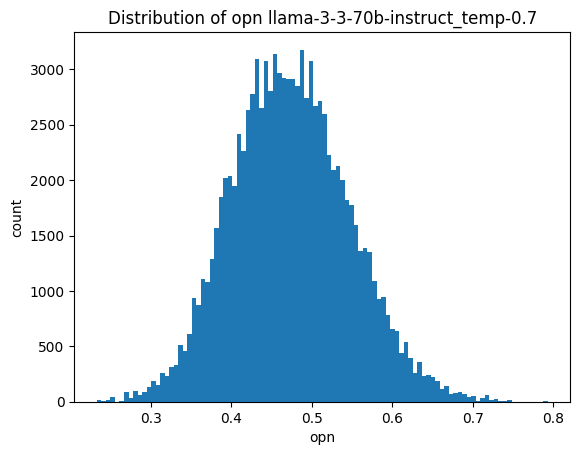

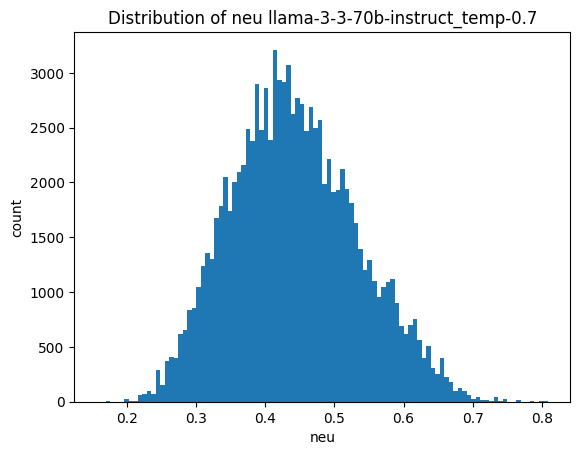

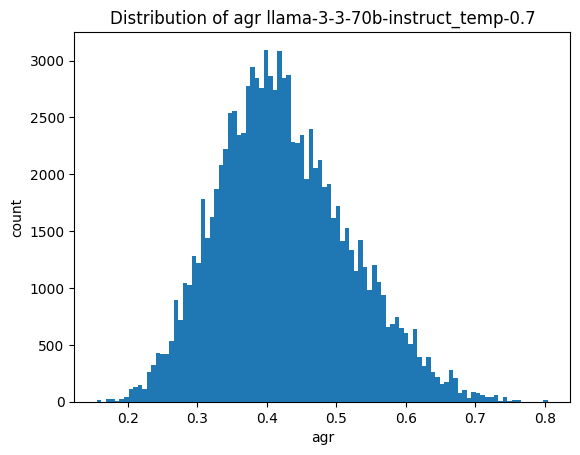

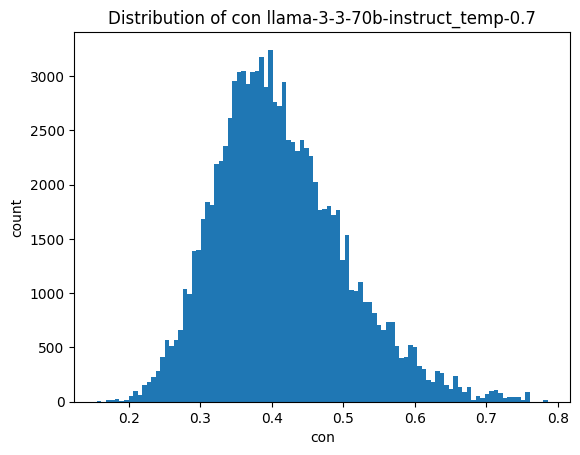

In [82]:
# read the dataframe and print a plot of the distribution of the ext value also add text in the plot explaining about it
plt.hist(df["ext"], bins=100)
plt.xlabel("ext")
plt.ylabel("count")
plt.title(f"Distribution of ext {modelname}")
plt.show()

plt.hist(df["opn"], bins=100)
plt.xlabel("opn")
plt.ylabel("count")
plt.title(f"Distribution of opn {modelname}")
plt.show()

plt.hist(df["neu"], bins=100)
plt.xlabel("neu")
plt.ylabel("count")
plt.title(f"Distribution of neu {modelname}")
plt.show()

plt.hist(df["agr"], bins=100)
plt.xlabel("agr")
plt.ylabel("count")
plt.title(f"Distribution of agr {modelname}")
plt.show()

plt.hist(df["con"], bins=100)
plt.xlabel("con")
plt.ylabel("count")
plt.title(f"Distribution of con {modelname}")
plt.show()





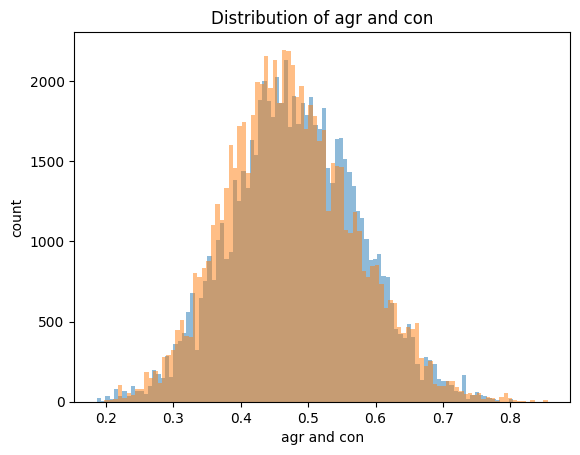

                                       generated_comment       agr
32797  I can't believe there are people who actually ...  0.187129
32798  I can't believe there are people who actually ...  0.187129
32799  I can't believe there are people who actually ...  0.187129
32800  I can't believe there are people who actually ...  0.187129
32801  I can't believe there are people who actually ...  0.187129
32802  I can't believe there are people who actually ...  0.187129
32803  I can't believe there are people who actually ...  0.187129
32804  I can't believe there are people who actually ...  0.187129
32805  I can't believe there are people who actually ...  0.187129
32806  I can't believe there are people who actually ...  0.187129
                                       generated_comment       con
32808  I've never understood the appeal of 98.5 The S...  0.198082
32809  I've never understood the appeal of 98.5 The S...  0.198082
32810  I've never understood the appeal of 98.5 The S...  0.19

In [32]:
# plot the distribution of con and agr on the same plot and add text so we can see what is what
plt.hist(df["agr"], bins=100, alpha=0.5, label="agr")
plt.hist(df["con"], bins=100, alpha=0.5, label="con")
plt.xlabel("agr and con")
plt.ylabel("count")
plt.title("Distribution of agr and con")
plt.show()

# find the 10 records with the lowest agr and con and print columns comment_text and their agr/con values
print(df.nsmallest(10, "agr")[["generated_comment", "agr"]])
print(df.nsmallest(10, "con")[["generated_comment", "con"]])




C:\Users\ARIK_LAP\AppData\Local\Temp\ipykernel_24156\1055049564.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=combined.index, y=combined.values, palette=colors, ax=ax)
C:\Users\ARIK_LAP\AppData\Local\Temp\ipykernel_24156\1055049564.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=combined.index, y=combined.values, palette=colors, ax=ax)
C:\Users\ARIK_LAP\AppData\Local\Temp\ipykernel_24156\1055049564.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=combined.index, y=combined.values, palette=colors, ax

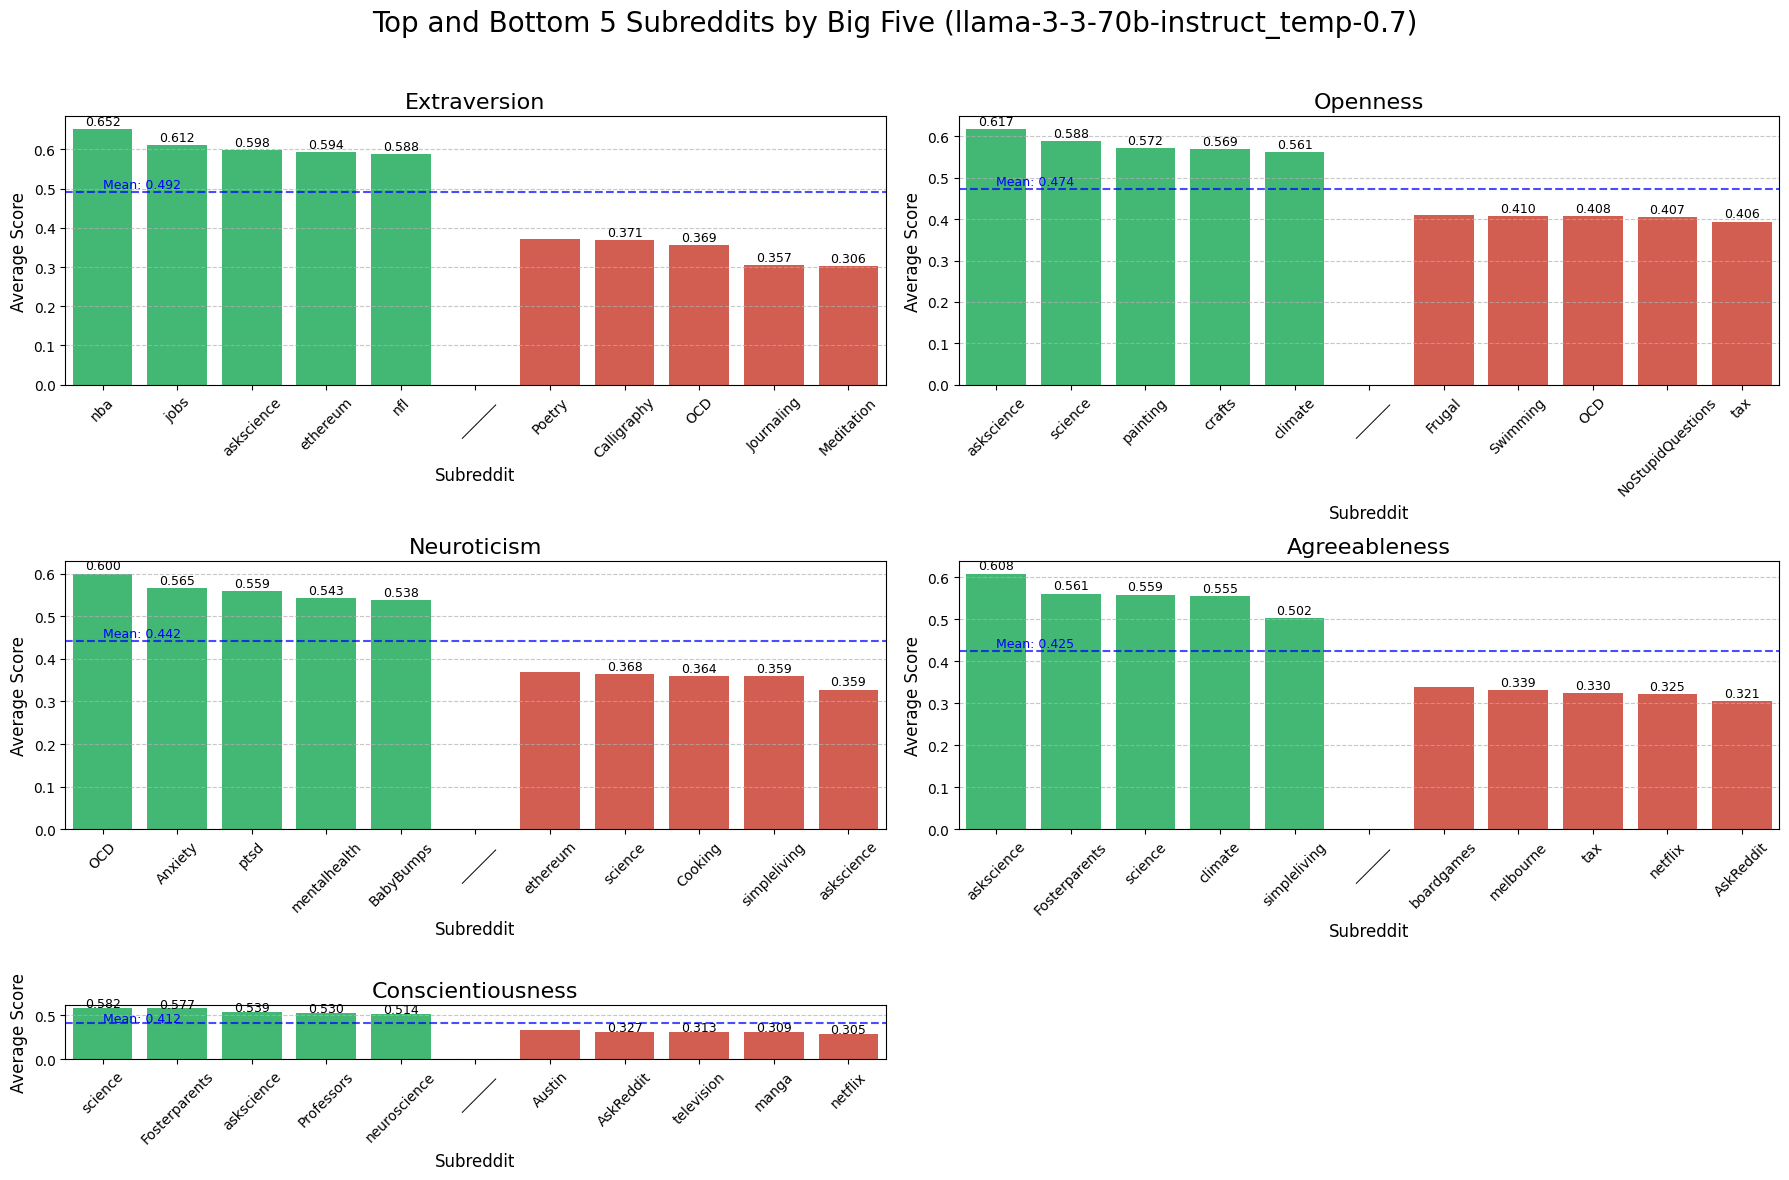

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is named 'df'
# List of personality traits to analyze
traits = ['ext', 'opn', 'neu', 'agr', 'con']
trait_names = {
    'ext': 'Extraversion',
    'opn': 'Openness',
    'neu': 'Neuroticism',
    'agr': 'Agreeableness',
    'con': 'Conscientiousness'
}

# Create a figure
plt.figure(figsize=(18, 12))

# Create a 3x2 grid of subplots (one extra for the legend)
gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 0.2])

# For each trait, plot top 5 and bottom 5 subreddits
for i, trait in enumerate(traits):
    # Calculate position in the grid
    row = i // 2
    col = i % 2

    # Create subplot
    ax = plt.subplot(gs[row, col])

    # Group by subreddit and calculate mean trait value
    trait_by_subreddit = df.groupby('post_subreddit')[trait].mean().sort_values(ascending=False)

    # Get top 5 and bottom 5
    top5 = trait_by_subreddit.head(5)
    bottom5 = trait_by_subreddit.tail(5)

    # Combine them with a separator
    combined = pd.concat([top5, pd.Series([np.nan], index=['_______']), bottom5])

    # Create a color map: green for top 5, red for bottom 5
    colors = ['#2ecc71']*5 + ['white'] + ['#e74c3c']*5

    # Plot
    bars = sns.barplot(x=combined.index, y=combined.values, palette=colors, ax=ax)

    # Add value labels on top of each bar
    for j, bar in enumerate(bars.patches):
        if j != 5:  # Skip the separator
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 0.01,
                f'{combined.values[j]:.3f}' if not np.isnan(combined.values[j]) else '',
                ha="center", fontsize=9
            )

    # Customize the subplot
    ax.set_title(f'{trait_names[trait]}', fontsize=16)
    ax.set_xlabel('Subreddit', fontsize=12)
    ax.set_ylabel(f'Average Score', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a horizontal line for the overall mean
    overall_mean = df[trait].mean()
    ax.axhline(y=overall_mean, color='blue', linestyle='--', alpha=0.7)
    ax.text(
        0, overall_mean + 0.01, 
        f'Mean: {overall_mean:.3f}', 
        color='blue', fontsize=9
    )

# Create a custom legend in the bottom subplot
legend_ax = plt.subplot(gs[2, :])
legend_ax.axis('off')
legend_handles = [
    plt.Rectangle((0,0),1,1, color='#2ecc71'),
    plt.Rectangle((0,0),1,1, color='#e74c3c'),
    plt.Line2D([0], [0], color='blue', linestyle='--')
]

plt.suptitle(f"Top and Bottom 5 Subreddits by Big Five ({modelname})", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#trait top and bottoms for reddit

# Trait top and bottom subreddits

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

min_num_of_comments = 50
# Assuming your DataFrame is named 'df'
# List of personality traits to analyze
traits = ['ext', 'opn', 'neu', 'agr', 'con']

#filename = "../data_for_analysis_200825/comments_reddit_OC.csv"

data_folder = "../data_for_analysis_200825"
output_folder = "./trait_by_subreddit_outputs"
os.makedirs(output_folder, exist_ok=True)

# === Loop through all comment CSV files ===
for filename in os.listdir(data_folder):
    if not filename.endswith(".csv"):
        continue  # skip non-csv files

    file_path = os.path.join(data_folder, filename)
    df = pd.read_csv(file_path)
    # For each trait, plot top 5 and bottom 5 subreddits
    for i, trait in enumerate(traits):

        df[trait] = pd.to_numeric(df[trait], errors='coerce')
        # Group by subreddit and calculate mean trait value
        trait_by_subreddit = df.groupby('post_subreddit').agg(
            mean_score=(trait, 'mean'),
            comment_count=(trait, 'count')
        ).sort_values(by='mean_score', ascending=False)
    
        # Get top 5 and bottom 5
        top5 = trait_by_subreddit.head(10)
        top5 = trait_by_subreddit[trait_by_subreddit['comment_count'] >= min_num_of_comments].head(10)

        bottom5 = trait_by_subreddit.tail(10)
        bottom5 = trait_by_subreddit[trait_by_subreddit['comment_count'] >= min_num_of_comments].tail(10)

        # Combine top5 and bottom5 into one DataFrame with labels
        top5_df = top5.reset_index().copy()
        top5_df['rank'] = 'Top'

        bottom5_df = bottom5.reset_index().copy()
        bottom5_df['rank'] = 'Bottom'

        # Concatenate them
        combined_df = pd.concat([top5_df, bottom5_df], ignore_index=True)

        # Optional: rename columns for clarity
        combined_df.columns = ['Subreddit', 'Average Trait Score', 'Comments count', 'Rank']
   
        # Derive model name from filename
        model_match = re.search(r'comments_(.*)\.csv', filename)
        model_name = model_match.group(1) if model_match else filename.replace('.csv', '')

        output_filename = f"{trait}_by_subreddit_{model_name}_min{min_num_of_comments}comments.csv"
        output_path = os.path.join(output_folder, output_filename)

        # Save to CSV
        combined_df.to_csv(output_path, index=False)
        print(f"CSV file saved as {output_path}")

CSV file saved as ./trait_by_subreddit_outputs\ext_by_subreddit_reddit_OC_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\opn_by_subreddit_reddit_OC_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\neu_by_subreddit_reddit_OC_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\agr_by_subreddit_reddit_OC_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\con_by_subreddit_reddit_OC_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\ext_by_subreddit_claude-sonnet-4-0_temp_0.0_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\opn_by_subreddit_claude-sonnet-4-0_temp_0.0_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\neu_by_subreddit_claude-sonnet-4-0_temp_0.0_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\agr_by_subreddit_claude-sonnet-4-0_temp_0.0_min50comments.csv
CSV file saved as ./trait_by_subreddit_outputs\con_by_subreddit_claude-sonnet-4-0_temp_0.0_min50comments

# Gender top and bottom subreddits

In [71]:
import pandas as pd
import os
import re

min_num_of_comments = 50
# === CONFIG ===
data_folder = "../data_for_analysis_200825"
output_folder = "./gender_by_subreddit_outputs"
os.makedirs(output_folder, exist_ok=True)

# Optional: filter files to only these gender labels
genders = ['female'] 

# === Loop through all comment CSV files ===
for filename in os.listdir(data_folder):
    if not filename.endswith(".csv"):
        continue  # skip non-csv files

    file_path = os.path.join(data_folder, filename)

    # Load the dataset
    try:
        df = pd.read_csv(file_path)

        if 'post_subreddit' in df.columns:
            df['post_subreddit'] = df['post_subreddit'].astype(str).str.strip()

            
    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        continue

    # Ensure required columns exist
    if 'post_subreddit' not in df.columns or 'score' not in df.columns:
        print(f"Skipping {filename}: missing 'post_subreddit' or 'score' column")
        continue

    print(f"\nProcessing: {filename}")
    print(df.info())

    # Group by subreddit and calculate mean gender score

    gender_by_subreddit = df.groupby('post_subreddit').agg(
    mean_score=('score', 'mean'),
    comment_count=('score', 'count')
            ).sort_values(by='mean_score', ascending=False)

    # Get top and bottom 10
    top10 = gender_by_subreddit[gender_by_subreddit['comment_count'] >= min_num_of_comments].head(10).reset_index().copy()
    bottom10 = gender_by_subreddit[gender_by_subreddit['comment_count'] >= min_num_of_comments].tail(10).reset_index().copy()

    top10['Rank'] = 'Top'
    bottom10['Rank'] = 'Bottom'

    # Combine results
    combined_df = pd.concat([top10, bottom10], ignore_index=True)
    combined_df.columns = ['Subreddit', 'Average Gender Score','Comments count', 'Rank']
    

    # Derive model name from filename
    model_match = re.search(r'comments_(.*)\.csv', filename)
    model_name = model_match.group(1) if model_match else filename.replace('.csv', '')

    output_filename = f"gender_by_subreddit_{model_name}_min{min_num_of_comments}comment.csv"
    output_path = os.path.join(output_folder, output_filename)

    # Save to CSV
    combined_df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")


Processing: comments_reddit_OC.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   post_id            11678 non-null  object 
 1   post_subreddit     11678 non-null  object 
 2   post_title         11678 non-null  object 
 3   post_text          11425 non-null  object 
 4   post_flair         11677 non-null  object 
 5   post_score         11678 non-null  int64  
 6   post_url           11662 non-null  object 
 7   post_created_utc   11678 non-null  int64  
 8   post_num_comments  11678 non-null  int64  
 9   comment_id         11678 non-null  object 
 10  generated_comment  11678 non-null  object 
 11  word_count         11678 non-null  int64  
 12  ext                11678 non-null  float64
 13  opn                11678 non-null  float64
 14  neu                11678 non-null  float64
 15  agr                11678 non-null 

# Mean statistical Test - Mannwhitney

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu
import os

traits = ['ext', 'opn', 'neu', 'agr', 'con']

results = []

data_folder = "../data_for_analysis_200825"
file = "../data_for_analysis_200825/comments_reddit_OC.csv"
# Load the dataset
df_Reddit = pd.read_csv(file)
df_Reddit = df_Reddit.drop_duplicates(subset=["post_id", "word_count", "generated_comment"])
        

for filename in os.listdir(data_folder):
    if not filename.endswith(".csv") and "reddit" in filename.lower(): 
        continue  # skip non-csv or Reddit files
    file_path = os.path.join(data_folder, filename)

    # Load the dataset
    try:
        df_model = pd.read_csv(file_path)
        
        # Count how many times each unique combination occurs
        dup_counts = df_model.groupby(["post_id", "word_count", "generated_comment"]).size()

        # Filter only those that appear more than once
        dup_counts = dup_counts[dup_counts > 1]

        # Sort descending to see the most duplicated comments first
        dup_counts = dup_counts.sort_values(ascending=False)

        print(dup_counts)

        df_model = df_model.drop_duplicates(subset=["post_id", "word_count", "generated_comment"])

    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        continue

    model_match = re.search(r'comments_(.*)\.csv', filename)
    model_name = model_match.group(1) if model_match else filename.replace('.csv', '')
    for trait in traits:
        
        human_scores = pd.to_numeric(df_Reddit[trait], errors='coerce').dropna()
        model_scores = pd.to_numeric(df_model[trait], errors='coerce').dropna()

        stat, p = mannwhitneyu(human_scores, model_scores, alternative='two-sided')
        
 
        results.append({
            "Model_File": model_name,
            "Trait": trait.upper(),
            "U_statistic": stat,
            "p_value": p,
            "Mean_Human": human_scores.mean(),
            "Mean_Model": model_scores.mean(),
            "N_Human": len(human_scores),
            "N_Model": len(model_scores)})
    
results_df = pd.DataFrame(results)
results_df.to_csv("mannwhitney_results.csv", index=False)
print ("finished")


post_id  word_count  generated_comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Std statitical test - Levene

In [3]:
import pandas as pd
from scipy.stats import levene
import re
import os

traits = ['ext', 'opn', 'neu', 'agr', 'con']

results = []

data_folder = "../data_for_analysis_200825/dedup"
file = "../data_for_analysis_200825/comments_reddit_OC.csv"
# Load the dataset
df_Reddit = pd.read_csv(file)
df_Reddit = df_Reddit.drop_duplicates(subset=["post_id", "word_count", "generated_comment"])
        

for filename in os.listdir(data_folder):
    if not filename.endswith(".csv") and "reddit" in filename.lower(): 
        continue  # skip non-csv or Reddit files
    file_path = os.path.join(data_folder, filename)

    # Load the dataset
    try:
        df_model = pd.read_csv(file_path)
        
        # Count how many times each unique combination occurs
        dup_counts = df_model.groupby(["post_id", "word_count", "generated_comment"]).size()

        # Filter only those that appear more than once
        dup_counts = dup_counts[dup_counts > 1]

        # Sort descending to see the most duplicated comments first
        dup_counts = dup_counts.sort_values(ascending=False)

        print(dup_counts)

        df_model = df_model.drop_duplicates(subset=["post_id", "word_count", "generated_comment"])

    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        continue

    model_match = re.search(r'comments_(.*)\.csv', filename)
    model_name = model_match.group(1) if model_match else filename.replace('.csv', '')
    for trait in traits:
        human_scores = pd.to_numeric(df_Reddit[trait], errors='coerce').dropna()
        model_scores = pd.to_numeric(df_model[trait], errors='coerce').dropna()

        stat, p = levene(human_scores, model_scores, center='mean')

 
        results.append({
            "Model_File": model_name,
            "Trait": trait.upper(),
            "Levene_statistic": stat,
            "p_value": p,
            "Mean_Human": human_scores.mean(),
            "Mean_Model": model_scores.mean(),
            "N_Human": len(human_scores),
            "N_Model": len(model_scores)})
    
results_df = pd.DataFrame(results)
results_df.to_csv("levene_results.csv", index=False)
print ("finished")


Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
finished


# Rename reddit comments file columns to match the generated by llm files.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load your real comments file
df_reddit_comments = pd.read_csv('Reddit_comments_over_100_under_300_words_no_quotes_with_predictions.csv')  

# Rename columns to match model output structure
df_comments_renamed = df_reddit_comments.rename(columns={
    'comment_text': 'generated_comment',
    'comment_word_count': 'word_count'
})
 
df_comments_renamed.to_csv("llm models with predictions/comments_Reddit_over_100_under_300_words_with_predictions.csv")

# add word_count column to gpt4.1 file



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = "llm models with predictions/generated_comments_claude-sonnet-4-0_temp_0.7_with_predictions.csv"

df = pd.read_csv(filename)  
df['word_count'] = df['generated_comment'].str.split().str.len()
df.to_csv(filename)

# Models comparison table

In [82]:
import pandas as pd
import os
import re

# Path to your folder containing model CSVs
#data_dir = 'llm models with predictions'
data_dir = "../data_for_analysis_200825"
output_filename = 'model_summary_stats.csv'
output_file = os.path.join(data_dir, output_filename)

# Create a dictionary to hold model name -> DataFrame
models = {}

# Loop through all CSV files in the directory
for filename in os.listdir(data_dir):

    if  re.search('comments', filename) and filename.endswith('.csv'):
        model_name =  filename.split("comments_")[1].split("_with")[0]
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)

        models[model_name] = df

traits = ['ext', 'opn', 'neu', 'agr', 'con']
results = []

for model_name, df in models.items():
    
    
    # Count duplicates based on the same subset you used earlier
    dup_count = df.duplicated(subset=["post_id", "word_count", "generated_comment"]).sum()

    print(f"{model_name}: {dup_count} duplicates")
    df = df.drop_duplicates(subset=["post_id", "word_count", "generated_comment"])
  
    # Group by post_id and sum word counts per post
    word_count_per_post = df.groupby("post_id")["word_count"].sum()

    # Get the max, min, and mean of the total word count per post
    max_wc = word_count_per_post.max()
    min_wc = word_count_per_post.min()
    mean_wc = word_count_per_post.mean()

    result = {
        'Model': model_name,
        'Total Comments': len(df),
        'Mean Comment word count': df['word_count'].mean(),

    }

    
    for trait in traits:
        result[f'{trait}_mean'] = pd.to_numeric(df[trait], errors='coerce').dropna().mean()
        result[f'{trait}_std'] = pd.to_numeric(df[trait], errors='coerce').std()

    result['Median comments word count'] = df['word_count'].median()
    result['Max comments word count'] = df['word_count'].max()
    result['Min comments word count'] = df['word_count'].min()
    result['Std comments word count'] = df['word_count'].std()
    result['Max word count per post'] = max_wc
    result['Min word count per post'] = min_wc
    result['Mean word count per post'] = mean_wc

    results.append(result)

summary_df = pd.DataFrame(results)
summary_df.to_csv(output_file, index=False)
print(summary_df)

reddit_OC.csv: 6 duplicates
claude-sonnet-4-0_temp_0.0.csv: 631 duplicates
claude-sonnet-4-0_temp_0.7.csv: 0 duplicates
gpt4.1-instruct_temp-0.0.csv: 31 duplicates
gpt4.1-instruct_temp-0.7.csv: 28 duplicates
gpt4.1Mini-instruct_temp-0.0.csv: 28 duplicates
gpt4.1Mini-instruct_temp-0.7.csv: 19 duplicates
llama-3-3-70b-instruct_temp-0.0.csv: 964 duplicates
llama-3-3-70b-instruct_temp-0.7.csv: 952 duplicates
mixtral-8x22B-instruct-v0.1_temp-0.0.csv: 1035 duplicates
mixtral-8x22B-instruct-v0.1_temp-0.7.csv: 437 duplicates
Qwen2.5-72B-Instruct_temp-0.0.csv: 3086 duplicates
Qwen2.5-72B-Instruct_temp-0.7.csv: 1304 duplicates
                                       Model  Total Comments  \
0                              reddit_OC.csv           11672   
1             claude-sonnet-4-0_temp_0.0.csv            9340   
2             claude-sonnet-4-0_temp_0.7.csv            8813   
3               gpt4.1-instruct_temp-0.0.csv            8315   
4               gpt4.1-instruct_temp-0.7.csv           

# Get examples of same post - and comments in different models

In [24]:
import pandas as pd
import os
import re

# === CONFIG ===
trait = 'score'
num_examples = 10
data_folder = '../data_for_analysis_200825'  # Update if needed
reddit_file = 'comments_reddit_OC.csv'

# === Step 1: Load Reddit comments ===
reddit_path = os.path.join(data_folder, reddit_file)
df_reddit = pd.read_csv(reddit_path)

# === Step 2: Load all model-generated files ===
model_dfs = {}
for filename in os.listdir(data_folder):
    if filename.endswith('.csv') and filename != reddit_file:
        file_path = os.path.join(data_folder, filename)

        # Extract model name from filename using regex
        match = re.search(r'generated_comments_(.*)_temp', filename)
        if match:
            model_name = match.group(1)
            df_model = pd.read_csv(file_path)
            model_dfs[model_name] = df_model
        else:
            print(f"Skipped file (could not extract model name): {filename}")

# === Step 3: Find common post_ids ===
common_post_ids = set(df_reddit['post_id'])
for df in model_dfs.values():
    common_post_ids &= set(df['post_id'])
print(f"Found {len(common_post_ids)} common posts across all models and Reddit.")

# === Step 4: Filter all DataFrames to only common posts ===
df_reddit = df_reddit[df_reddit['post_id'].isin(common_post_ids)].copy()
for model in model_dfs:
    model_dfs[model] = model_dfs[model][model_dfs[model]['post_id'].isin(common_post_ids)].copy()

# === Step 5: Get top posts by Reddit trait score ===
post_scores = df_reddit.groupby('post_id')[trait].mean().reset_index(name='trait_score')
top_post_ids = post_scores.sort_values('trait_score', ascending=False).head(num_examples)['post_id']

# === Step 6: Build output ===
output_lines = []

for pid in top_post_ids:
    post_row = df_reddit[df_reddit['post_id'] == pid].iloc[0]
    post_title = post_row['post_title']
    post_text = post_row.get('post_text', '')
    reddit_comment = post_row['generated_comment']
    reddit_score =round(float(post_row[trait]), 5)

    output_lines.append(f"Post: {post_title}\n{post_text}\n")
    output_lines.append(f"Reddit author comment: {reddit_comment} ... score: {reddit_score}\n")

    for model_name, df_model in model_dfs.items():
        model_row = df_model[df_model['post_id'] == pid].iloc[0]
        model_comment = model_row['generated_comment']
        model_score = round(float(model_row[trait]), 5)
        output_lines.append(f"{model_name} comment: {model_comment} ... score: {model_score}\n")

    output_lines.append("\n" + "="*80 + "\n")

# === Step 7: Save output to text file ===
output_file = f"{trait}_top{num_examples}_all_models.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    f.write('\n'.join(output_lines))

print(f"Saved output to {output_file}")

Found 285 common posts across all models and Reddit.
Saved output to score_top10_all_models.txt
